In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython.display import display
from ipywidgets import interact


In [2]:
# Add project root to sys.path
notebook_dir = os.getcwd()  # Should be src/notebooks/
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [3]:
project_root 

'/mnt/nfs/rad/data/mskscratch/users/ghoyer/Precision_Air/VLS_auto_grader/src'

In [4]:
# Now use absolute imports
from utils import load_config
from utils.project import get_project_root
from dataset import MultiGraderDataset, PretrainingDataset
from utils.augmentations import get_transforms, get_ssl_transforms
from utils.visualization import plot_augmentations, plot_pretrain_augmentations

In [6]:
%matplotlib inline


def visualize_augmentations(cfg, config_path, pretrain_method=None, n_frames=4, num_samples=2):
    """
    Visualize augmentations for supervised learning and SSL pretraining in a Jupyter notebook.
    
    Args:
        cfg (dict): Configuration dictionary loaded from YAML.
        config_path (str): Path to the configuration YAML file.
        pretrain_method (str, optional): Pretraining method ('moco', 'contrastive', 'mae'). Required if SSL pretraining is enabled.
        n_frames (int): Number of frames to visualize per video.
        num_samples (int): Number of samples to visualize.
    """
    # Set up paths
    figures_dir = os.path.join(get_project_root(), cfg['paths']['figures_dir'])
    os.makedirs(figures_dir, exist_ok=True)
    run_id = "notebook_viz"

    # Load data
    df = pd.read_csv(cfg['paths']['data_csv'])
    train_df = df[df['split'] == 'train']
    val_df = df[df['split'] == 'val']
    hierarchical = cfg['training']['num_subclasses'] > 0

    # --- Supervised Learning Augmentations ---
    print("Visualizing Supervised Learning Augmentations")
    
    # Train dataset
    train_transforms = get_transforms(is_train=True)
    train_dataset = MultiGraderDataset(
        video_paths=train_df[cfg['training']['datamodule']['video_col']].tolist(),
        labels=train_df[cfg['training']['datamodule']['label_cols']].values.tolist(),
        transform=train_transforms,
        hierarchical=hierarchical
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=num_samples,
        shuffle=True,
        num_workers=cfg['training']['num_workers']
    )

    # Validation dataset
    val_transforms = get_transforms(is_train=False)
    val_dataset = MultiGraderDataset(
        video_paths=val_df[cfg['training']['datamodule']['video_col']].tolist(),
        labels=val_df[cfg['training']['datamodule']['label_cols']].values.tolist(),
        transform=val_transforms,
        hierarchical=hierarchical
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=num_samples,
        shuffle=True,
        num_workers=cfg['training']['num_workers']
    )

    # Visualize train augmentations
    print("Train Augmentations:")
    fig = plot_augmentations(
        train_loader,
        run_path=get_project_root(),
        fig_dir=cfg['paths']['figures_dir'],
        run_id=run_id,
        prefix='train_notebook',
        n_frames=n_frames,
        save_path=None,  # Don't save, just display
        close_fig=False  # Keep figure open for inline display
    )
    plt.show()

    # Visualize validation augmentations
    print("Validation Augmentations:")
    fig = plot_augmentations(
        val_loader,
        run_path=get_project_root(),
        fig_dir=cfg['paths']['figures_dir'],
        run_id=run_id,
        prefix='val_notebook',
        n_frames=n_frames,
        save_path=None,
        close_fig=False
    )
    plt.show()

    # --- SSL Pretraining Augmentations ---
    if cfg['training']['ssl_pretrain'] and pretrain_method:
        print(f"Visualizing SSL Pretraining Augmentations for {pretrain_method}")
        
        # Create base dataset without transforms
        base_dataset = MultiGraderDataset(
            video_paths=train_df[cfg['training']['datamodule']['video_col']].tolist(),
            labels=[["0"]] * len(train_df),  # Dummy labels
            transform=None,
            is_ssl=True,
            hierarchical=hierarchical
        )

        # Create pretraining dataset with SSL augmentations
        ssl_transform = get_ssl_transforms(pretrain_method)
        pretrain_dataset = PretrainingDataset(
            base_dataset,
            pretrain_method,
            cfg,
            ssl_transform=ssl_transform
        )
        pretrain_loader = DataLoader(
            pretrain_dataset,
            batch_size=num_samples,
            shuffle=True,
            num_workers=cfg['training']['num_workers']
        )

        # Visualize pretraining augmentations
        fig = plot_pretrain_augmentations(
            pretrain_loader,
            run_path=get_project_root(),
            fig_dir=cfg['paths']['figures_dir'],
            run_id=run_id,
            pretrain_method=pretrain_method,
            n_frames=n_frames,
            save_path=None,
            close_fig=False
        )
        plt.show()
        


In [7]:
# Example usage
config_path = os.path.join(get_project_root(), 'config', 'hierarchical_singlegrader_ssl.yaml')
# hierarchical_multigrader_ssl
cfg = load_config(config_path)

cfg


{'experiment': {'name': 'VLS_3D_Grading_Hierarchical_SingleGrader_SSL',
  'description': 'Hierarchical single-grader training with SSL pretraining.'},
 'paths': {'data_csv': '/mnt/nfs/rad/data/mskscratch/users/ghoyer/Precision_Air/VLS_auto_grader/data/video_splits_corrected.csv',
  'log_dir': 'logs',
  'checkpoint_dir': 'checkpoints',
  'figures_dir': 'figures',
  'summaries_dir': 'summaries'},
 'output_configuration': {'work_dir': 'work_dir/runs',
  'task_name': 'vls_grading',
  'use_wandb': False,
  'checkpoint_interval': 5,
  'logging_level': 'INFO'},
 'training': {'datamodule': {'video_col': 'Processed_video_path',
   'label_cols': ['Sean_Review']},
  'model_name': 'i3d',
  'num_base_classes': 4,
  'num_subclasses': 5,
  'num_classes': 8,
  'batch_size': 8,
  'num_workers': 4,
  'lr': 0.0001,
  'ssl_lr': 0.001,
  'epochs': 1,
  'ssl_epochs': 1,
  'ssl_pretrain': True,
  'pretrain_method': 'moco',
  'subclass_loss_weight': 0.5,
  'module': {'use_amp': True,
   'clip_grad': 1.0,
   '

In [8]:
config_path

'/mnt/nfs/rad/data/mskscratch/users/ghoyer/Precision_Air/VLS_auto_grader/config/hierarchical_singlegrader_ssl.yaml'

Visualizing Supervised Learning Augmentations
Train Augmentations:


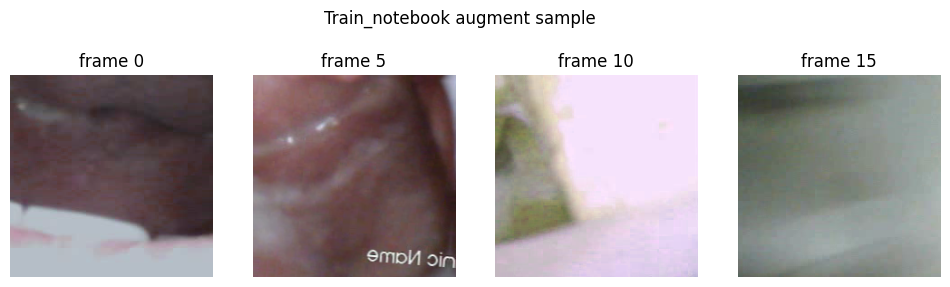

Validation Augmentations:


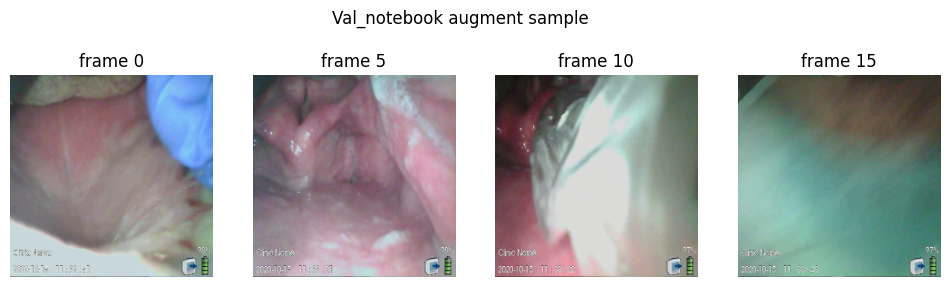

In [9]:
# Visualize supervised augmentations only
visualize_augmentations(cfg, config_path, pretrain_method=None)

Visualizing Supervised Learning Augmentations
Train Augmentations:


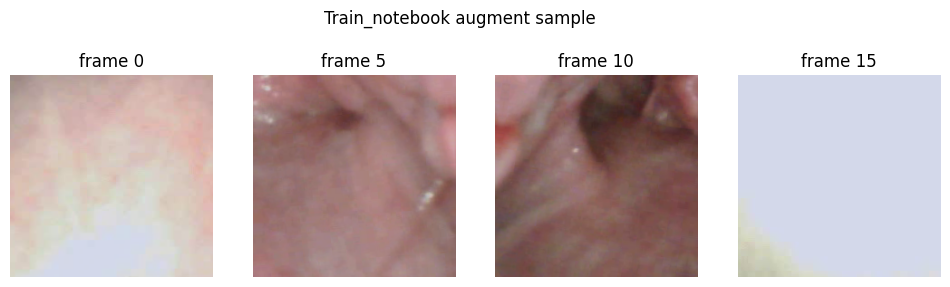

Validation Augmentations:


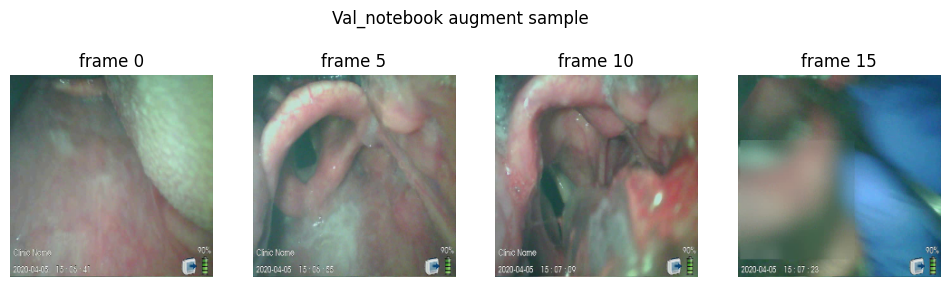

Visualizing SSL Pretraining Augmentations for moco


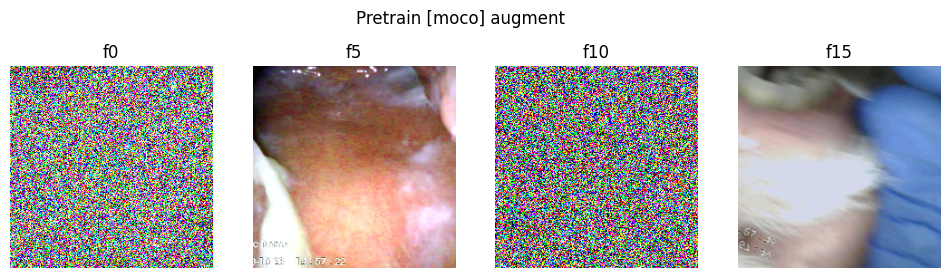

In [10]:
# Visualize both supervised and SSL augmentations (e.g., for 'moco')
visualize_augmentations(cfg, config_path, pretrain_method='moco')

In [11]:
# from ipywidgets import interact
@interact(n_frames=(1, 8), num_samples=(1, 4))
def interactive_viz(n_frames, num_samples):
    visualize_augmentations(cfg, config_path, pretrain_method='moco', n_frames=n_frames, num_samples=num_samples)

interactive(children=(IntSlider(value=4, description='n_frames', max=8, min=1), IntSlider(value=2, description…

In [12]:
# from ipywidgets import interact
@interact(n_frames=(1, 8), num_samples=(1, 4))
def interactive_viz(n_frames, num_samples):
    visualize_augmentations(cfg, config_path, pretrain_method='contrastive', n_frames=n_frames, num_samples=num_samples)

interactive(children=(IntSlider(value=4, description='n_frames', max=8, min=1), IntSlider(value=2, description…

In [13]:
# from ipywidgets import interact
@interact(n_frames=(1, 8), num_samples=(1, 4))
def interactive_viz(n_frames, num_samples):
    visualize_augmentations(cfg, config_path, pretrain_method='mae', n_frames=n_frames, num_samples=num_samples)

interactive(children=(IntSlider(value=4, description='n_frames', max=8, min=1), IntSlider(value=2, description…